### Overfit 개선을 위한 L1, L2 규제의 적용

In [1]:
# %autosave 0
import numpy as np
import pandas as pd
import seaborn as sb
import tensorflow as tf

from tensorflow.keras.models import Sequential  # class
from tensorflow.keras.models import load_model  # model 사용
from tensorflow.keras.layers import Dense       # 전결합
from tensorflow.keras.layers import Dropout     # 특정 node를 사용안함.
from tensorflow.keras.callbacks import EarlyStopping # 학습 자동 중지
from tensorflow.keras import regularizers   # L1, L2 규제 적용

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold  # K 겹 교차 검증
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve

import matplotlib
import matplotlib.pyplot as plt
from matplotlib import font_manager, rc

font_name = font_manager.FontProperties(fname="C:/Windows/Fonts/malgunsl.ttf").get_name()
rc('font', family=font_name)           # 맑은 고딕 폰트 지정
plt.rcParams["font.size"] = 12         # 글자 크기
# plt.rcParams["figure.figsize"] = (10, 4) # 10:4의 그래프 비율
plt.rcParams['axes.unicode_minus'] = False  # minus 부호는 unicode 적용시 한글이 깨짐으로 설정

# Jupyter에게 matplotlib 그래프를 출력 영역에 표시할 것을 지시하는 명령
%matplotlib inline  

In [2]:
data = np.loadtxt('./Survival.csv', delimiter=",", dtype=np.float64)
print(type(data))
print(data.shape)

<class 'numpy.ndarray'>
(470, 18)


In [3]:
X = data[:, 0:17] # 0 ~ 16: 17개
print(X.shape)
Y = data[:, 17]   # 17: 1개
print(Y.shape)

(470, 17)
(470,)


In [4]:
# train_test_split 분할을 통한 훈련, 검증, 테스트 데이터의 분리
seed = 0
# 90%: 분할대기(x_train_all), 10%: 테스트(x_test)
x_train_all, x_test, y_train_all, y_test = train_test_split(X, Y,
                                                          stratify=Y,
                                                          test_size=0.1,
                                                          random_state=seed)
# 약한 Overfit
# 나머지 데이터 90%를 분할, 70%: 훈련(x_train), 30%: 검증(x_val)

# 강한 Overfit
# 나머지 데이터 90%를 분할, 90%: 훈련(x_train), 10%: 검증(x_val)
x_train, x_val, y_train, y_val = train_test_split(x_train_all, y_train_all,
                                                  stratify=y_train_all,
                                                  test_size=0.1,
                                                  random_state=seed)

print(y_val[0:100])
print(y_val.shape)

[0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
(43,)


In [1]:
def l1l2():
    tf.random.set_seed(0)
    model = Sequential()
    # model.add(Dense(128, input_dim=17, activation='linear')) 
    model.add(Dense(128, input_shape=(17, ), activation='relu',
              kernel_regularizer=regularizers.l1_l2(l1=0.0001, l2=0.0001))) 
    model.add(Dense(64, activation='relu',
              kernel_regularizer=regularizers.l1_l2(l1=0.0001, l2=0.0001)))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(15, activation='relu'))
    model.add(Dense(1, activation='sigmoid')) # 출력층, 입력: 15, 출력 1

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    model.summary()

    # 오차가 16번 증가되면 종료, Overfit 발생을위해 과도한 학습 진행
    es = EarlyStopping(monitor='loss', patience=16, restore_best_weights=True)

    # 학습
    hist = model.fit(x_train, y_train, validation_data=(x_val, y_val),
                     epochs=1000, 
                     batch_size=2, callbacks=[es])
    
    fig, loss_ax = plt.subplots()
    # plt.figure(figsize=(6,4)) # ERROR
    fig.set_size_inches(10, 5)  # 챠트 크기 설정

    acc_ax = loss_ax.twinx()  # 오른쪽 y 출 설정

    # 왼쪽 y 축 설정
    loss_ax.plot(hist.history['loss'], 'y', label='train loss')
    loss_ax.plot(hist.history['val_loss'], 'r', label='val loss')
    loss_ax.set_ylim([0.0, 1.0229]) # 값을 반영하여 변경

    # 오른쪽 y 축 설정
    acc_ax.plot(hist.history['accuracy'], 'b', label='train accuracy')
    acc_ax.plot(hist.history['val_accuracy'], 'g', label='val accuracy')
    acc_ax.set_ylim([0.0, 1]) # 0.0, 1: 0 ~ 100 %, 정확도임으로 변경하지 않음

    # 축 레이블 설정
    loss_ax.set_xlabel('epoch')  # 학습 횟수
    loss_ax.set_ylabel('loss')   # 오차
    acc_ax.set_ylabel('accuracy') # 정확도

    loss_ax.legend(loc='upper left') # 오차 레이블 위치
    acc_ax.legend(loc='lower left')  # 정확도 레이블 위치

    plt.show()
    
    test_loss, test_acc = model.evaluate(x_test, y_test, batch_size=1, verbose=0)
    print('손실값:', test_loss, '/정확도:', (test_acc*100), '%')
    
    return model, hist

### Dropout 사용의 경우

In [22]:
# Dropout 사용의 경우
def dropout_use():
    tf.random.set_seed(0)
    model = Sequential()
    # model.add(Dense(128, input_dim=17, activation='linear')) # 첫번째 은닉층
    model.add(Dense(128, input_shape=(17, ), activation='relu')) # 첫번째 은닉층
    model.add(Dropout(0.2)) # 20% 비활성화, Node의 값을 0으로 변경

    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.2)) # 20% 비활성화, Node의 값을 0으로 변경

    model.add(Dense(32, activation='relu'))
    model.add(Dense(15, activation='relu'))
    model.add(Dense(1, activation='sigmoid')) # 출력층, 입력: 15, 출력 1

    model.compile(optimizer='adam', loss='binary_crossentropy',
                  metrics=['accuracy'])
    model.summary()

    # 오차가 16번 증가되면 종료, Overfit 발생을위해 과도한 학습 진행
    es = EarlyStopping(monitor='loss', patience=16, restore_best_weights=True)

    # 학습
    hist = model.fit(x_train, y_train, validation_data=(x_val, y_val),
                     epochs=1000, 
                     batch_size=2, callbacks=[es])
    
    fig, loss_ax = plt.subplots()
    # plt.figure(figsize=(6,4)) # ERROR
    fig.set_size_inches(10, 5)  # 챠트 크기 설정

    acc_ax = loss_ax.twinx()  # 오른쪽 y 출 설정

    # 왼쪽 y 축 설정
    loss_ax.plot(hist.history['loss'], 'y', label='train loss')
    loss_ax.plot(hist.history['val_loss'], 'r', label='val loss')
    loss_ax.set_ylim([0.0, 1.0229]) # 값을 반영하여 변경

    # 오른쪽 y 축 설정
    acc_ax.plot(hist.history['accuracy'], 'b', label='train accuracy')
    acc_ax.plot(hist.history['val_accuracy'], 'g', label='val accuracy')
    acc_ax.set_ylim([0.0, 1]) # 0.0, 1: 0 ~ 100 %, 정확도임으로 변경하지 않음

    # 축 레이블 설정
    loss_ax.set_xlabel('epoch')  # 학습 횟수
    loss_ax.set_ylabel('loss')   # 오차
    acc_ax.set_ylabel('accuracy') # 정확도

    loss_ax.legend(loc='upper left') # 오차 레이블 위치
    acc_ax.legend(loc='lower left')  # 정확도 레이블 위치

    plt.show()
    
    test_loss, test_acc = model.evaluate(x_test, y_test, batch_size=1, verbose=0)
    print('손실값:', test_loss, '/정확도:', (test_acc*100), '%')
   
    return model, hist

In [23]:
# L1, L2, Dropout 사용의 경우
def l1l2_dropout():
    tf.random.set_seed(0)
    model = Sequential()
    # model.add(Dense(128, input_dim=17, activation='linear')) 
    
    model.add(Dense(128, input_shape=(17, ), activation='relu',
              kernel_regularizer=regularizers.l1_l2(l1=0.0001, l2=0.0001)))
    model.add(Dropout(0.1)) # 10% 비활성화, Node의 값을 0으로 변경

    model.add(Dense(64, activation='relu',
              kernel_regularizer=regularizers.l1_l2(l1=0.0001, l2=0.0001)))
    model.add(Dropout(0.1)) # 10% 비활성화, Node의 값을 0으로 변경

    model.add(Dense(32, activation='relu'))
    model.add(Dense(15, activation='relu'))
    model.add(Dense(1, activation='sigmoid')) # 출력층, 입력: 15, 출력 1

    model.compile(optimizer='adam', loss='binary_crossentropy',
                  metrics=['accuracy'])
    model.summary()
    
    # 오차가 16번 증가되면 종료, Overfit 발생을위해 과도한 학습 진행
    es = EarlyStopping(monitor='loss', patience=16, restore_best_weights=True)

    # 학습
    hist = model.fit(x_train, y_train, validation_data=(x_val, y_val),
                     epochs=1000, 
                     batch_size=2, callbacks=[es])
    
    fig, loss_ax = plt.subplots()
    # plt.figure(figsize=(6,4)) # ERROR
    fig.set_size_inches(10, 5)  # 챠트 크기 설정

    acc_ax = loss_ax.twinx()  # 오른쪽 y 출 설정

    # 왼쪽 y 축 설정
    loss_ax.plot(hist.history['loss'], 'y', label='train loss')
    loss_ax.plot(hist.history['val_loss'], 'r', label='val loss')
    loss_ax.set_ylim([0.0, 1.0229]) # 값을 반영하여 변경

    # 오른쪽 y 축 설정
    acc_ax.plot(hist.history['accuracy'], 'b', label='train accuracy')
    acc_ax.plot(hist.history['val_accuracy'], 'g', label='val accuracy')
    acc_ax.set_ylim([0.0, 1]) # 0.0, 1: 0 ~ 100 %, 정확도임으로 변경하지 않음

    # 축 레이블 설정
    loss_ax.set_xlabel('epoch')  # 학습 횟수
    loss_ax.set_ylabel('loss')   # 오차
    acc_ax.set_ylabel('accuracy') # 정확도

    loss_ax.legend(loc='upper left') # 오차 레이블 위치
    acc_ax.legend(loc='lower left')  # 정확도 레이블 위치

    plt.show()
    
    test_loss, test_acc = model.evaluate(x_test, y_test, batch_size=1, verbose=0)
    print('손실값:', test_loss, '/정확도:', (test_acc*100), '%')

    return model, hist


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_10 (Dense)             (None, 128)               2304      
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 64)                8256      
_________________________________________________________________
dropout_3 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_12 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_13 (Dense)             (None, 15)                495       
_________________________________________________________________
dense_14 (Dense)             (None, 1)                

Epoch 49/1000
190/190 [==============================] - 0s 1ms/step - loss: 0.4046 - accuracy: 0.8729 - val_loss: 0.4352 - val_accuracy: 0.8605
Epoch 50/1000
190/190 [==============================] - 0s 1ms/step - loss: 0.4386 - accuracy: 0.8504 - val_loss: 0.4395 - val_accuracy: 0.8605
Epoch 51/1000
190/190 [==============================] - 0s 1ms/step - loss: 0.4693 - accuracy: 0.8326 - val_loss: 0.4358 - val_accuracy: 0.8605
Epoch 52/1000
190/190 [==============================] - 0s 1ms/step - loss: 0.4428 - accuracy: 0.8467 - val_loss: 0.4438 - val_accuracy: 0.8605
Epoch 53/1000
190/190 [==============================] - 0s 1ms/step - loss: 0.4773 - accuracy: 0.8191 - val_loss: 0.4329 - val_accuracy: 0.8605
Epoch 54/1000
190/190 [==============================] - 0s 1ms/step - loss: 0.4046 - accuracy: 0.8639 - val_loss: 0.4329 - val_accuracy: 0.8605
Epoch 55/1000
190/190 [==============================] - 0s 1ms/step - loss: 0.4248 - accuracy: 0.8544 - val_loss: 0.4343 - val_ac

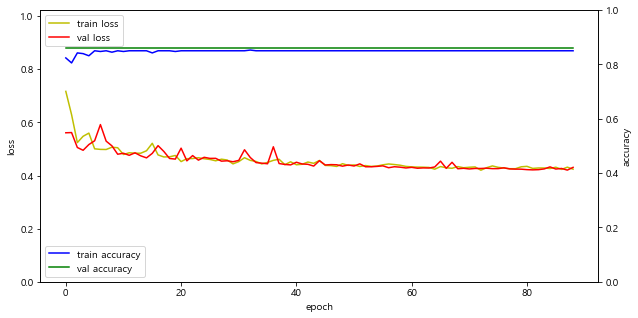

손실값: 0.4315280616283417 /정확도: 85.10638475418091 %


In [24]:
# model, hist = l1l2() 

# model, hist = dropout_use() 

model, hist = l1l2_dropout()